In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
# Load Data
path = untar_data(URLs.MNIST)

In [6]:
path

WindowsPath('C:/Users/bokhy/.fastai/data/mnist_png')

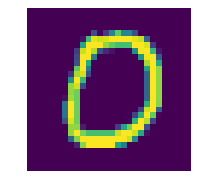

In [4]:
# 1. Create imagelist
il = ImageList.from_folder(path, convert_mode='L')
il
il[0].show()

In [7]:
defaults.cmap='binary'

In [8]:
sd = il.split_by_folder(train='training', valid='testing')
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: C:\Users\bokhy\.fastai\data\mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: C:\Users\bokhy\.fastai\data\mnist_png;

Test: None

In [9]:
# 2. take imagelist and label it (by folder in this case)
ll = sd.label_from_folder()
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: C:\Users\bokhy\.fastai\data\mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: C:\Users\bokhy\.fastai\data\mnist_png;

Test: None

In [10]:
x,y = ll.train[0]

In [11]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])
tfms

([RandTransform(tfm=TfmPixel (pad), kwargs={'padding': 3, 'mode': 'zeros'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (crop), kwargs={'size': 28, 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [])

In [12]:
# 3. Transform
ll = ll.transform(tfms)

In [13]:
#batch size
bs = 32

In [14]:
# 4.databunch 
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()
data

ImageDataBunch;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: C:\Users\bokhy\.fastai\data\mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: C:\Users\bokhy\.fastai\data\mnist_png;

Test: None

In [15]:
x,y = data.train_ds[0]

0


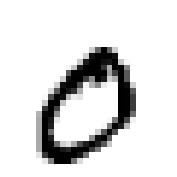

In [16]:
x.show()
print(y)

In [17]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([28, 1, 28, 28]), torch.Size([28]))

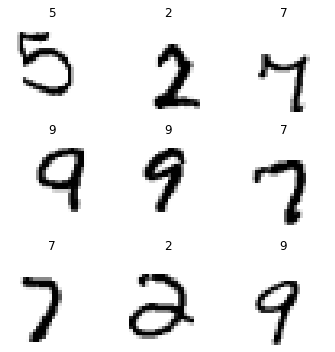

In [18]:
data.show_batch(rows=3, figsize=(5,5))

In [19]:
## Basic CNN with batchnorm

In [20]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [21]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [22]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [23]:
xb = xb.cuda()
model(xb).shape

torch.Size([28, 10])

In [24]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


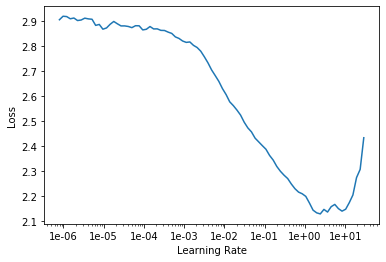

In [25]:
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.358661,0.303763,0.902700,01:55
1,0.173309,0.122332,0.961500,01:50
2,0.095996,0.047142,0.985600,01:52


In [ ]:
## Using fastai version

In [27]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [28]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


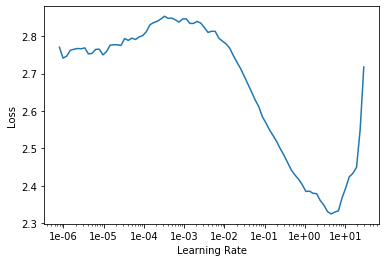

In [29]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.323802,0.154137,0.954100,01:43
1,0.265099,0.160194,0.949700,01:44
2,0.290638,0.313892,0.904300,01:44
3,0.285804,0.596903,0.801100,01:44
4,0.300262,0.325268,0.898900,01:41
5,0.229259,0.146741,0.957200,02:01
6,0.183178,0.090863,0.974000,01:52
7,0.106404,0.051761,0.984200,01:35
8,0.091911,0.039558,0.989100,01:49
9,0.083305,0.033296,0.989200,01:50


## Resnet-ish --> #skip connection.

In [31]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [32]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


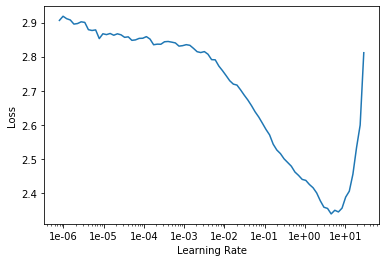

In [33]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.228893,0.136044,0.965100,02:42
1,0.170586,0.104724,0.969300,02:25
2,0.163270,0.165926,0.964100,02:25
3,0.148630,3.654489,0.951700,02:25
4,0.137074,0.066778,0.980700,02:26
5,0.132727,0.081799,0.975500,02:26
6,0.103128,0.078956,0.977900,02:26
7,0.104520,0.075536,0.978000,02:26
8,0.061379,0.040652,0.987500,02:26
9,0.037959,0.023798,0.992800,02:26
